In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from torch.nn import functional as F
from PIL import Image
import pandas as pd
import torchvision.transforms.functional as IFU
import os
from sklearn.model_selection import train_test_split
import zipfile

# Define paths for extraction
zip_path_train = '/content/train_dataset.zip'


extract_path_train = '/content/train_dataset'


# Function to extract a zip file
def extract_zip(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Extract train_dataset.zip
extract_zip(zip_path_train, extract_path_train)
print(f"Train dataset extracted to {extract_path_train}")



Train dataset extracted to /content/train_dataset


In [2]:
# Load train.csv
train_csv = pd.read_csv("train.csv")  # Replace with the actual path to your train.csv

# Mappings for converting labels to integers and vice-versa
label_to_int_map = {
    'bright dune': 0,
    'dark dune': 1,
    'spider': 2,
    'impact ejecta': 3,
    'slope streak': 4,
    'swiss cheese': 5,
    'crater': 6,
    'other': 7
}

int_to_label_map = {v:k for k, v in label_to_int_map.items()}


# Replace labels with integers
labels_int = train_csv['Class'].replace(label_to_int_map).tolist()

# Construct file paths considering nested structure
file_names = train_csv['File Name']
new_file_names = [os.path.join(extract_path_train, 'train_dataset', fname) for fname in file_names]

In [3]:

# Split into train and test datasets
x_train, x_val, y_train, y_val = train_test_split(new_file_names, labels_int, test_size=0.25, random_state=42)

# Create DataFrames
train_df = pd.DataFrame({'file_path': x_train, 'label': y_train})
val_df = pd.DataFrame({'file_path': x_val, 'label': y_val})

In [4]:
freq_df = train_df['label'].value_counts()
print(freq_df)

# Separate the DataFrame into different classes based on the label
df0 = train_df[train_df['label'] == 0].copy()
df1 = train_df[train_df['label'] == 1].copy()
df2 = train_df[train_df['label'] == 2].copy()
df3 = train_df[train_df['label'] == 3].copy()
df4 = train_df[train_df['label'] == 4].copy()
df5 = train_df[train_df['label'] == 5].copy()
df6 = train_df[train_df['label'] == 6].copy()
df7 = train_df[train_df['label'] == 7].copy()

# Duplicate and shuffle the data
df0 = pd.concat([df0 for k in range(2)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df1 = pd.concat([df1 for k in range(4)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df2 = pd.concat([df2 for k in range(9)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df3 = pd.concat([df3 for k in range(11)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df4 = pd.concat([df4 for k in range(4)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df5 = pd.concat([df5 for k in range(4)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df6 = pd.concat([df6 for k in range(2)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df7 = pd.concat([df7 for k in range(1)], ignore_index=True).sample(frac=1).reset_index(drop=True)

# Concatenate all the data back into a single DataFrame and shuffle
train_df_all = pd.concat([df0, df1, df2, df3, df4, df5, df6, df7], ignore_index=True).sample(frac=1).reset_index(drop=True)
print(train_df_all['label'].value_counts())

# Define the number of examples to be taken from each class
noel = [650, 375, 350, 350, 750, 475, 1150, 1400]

# Create two new training DataFrames with specific number of examples from each class
train_df_1 = pd.concat([df0[:noel[0]],
                         df1[:noel[1]],
                         df2[:noel[2]],
                         df3[:noel[3]],
                         df4[:noel[4]],
                         df5[:noel[5]],
                         df6[:noel[6]],
                         df7[:noel[7]]], ignore_index=True).sample(frac=1).reset_index(drop=True)

train_df_2 = pd.concat([df0[-noel[0]:],
                         df1[-noel[1]:],
                         df2[-noel[2]:],
                         df3[-noel[3]:],
                         df4[-noel[4]:],
                         df5[-noel[5]:],
                         df6[-noel[6]:],
                         df7[-noel[7]:]], ignore_index=True).sample(frac=1).reset_index(drop=True)

# Print the shapes of the new DataFrames
print(train_df_1.shape, train_df_2.shape)

label
7    2735
6     782
0     454
4     260
5     169
1     166
2      47
3      37
Name: count, dtype: int64
label
7    2735
6    1564
4    1040
0     908
5     676
1     664
2     423
3     407
Name: count, dtype: int64
(5500, 2) (5500, 2)


In [5]:
'''
Creating a class that will take in the train/test filenames dataframe
as input and import and store images as a tuple: (image tensor, integer label)

'''
# Dataset class for Mars images
class MarsImgDataset(Dataset):
    def __init__(self, img_df, transform=None):
        self.img_df = img_df
        self.transform = transform

    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, idx):
        img_path = self.img_df.iloc[idx, 0]
        label = self.img_df.iloc[idx, 1]

        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        image = IFU.adjust_contrast(image, 1.75)

        return image, label


In [6]:
# Define transformation for images
import random

IMAGE_SIZE = (224, 224)


data_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ColorJitter(brightness=0.1, contrast=0.3, saturation=0.3, hue=0),

    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])





train_dataset_1 = MarsImgDataset(train_df_1, data_transform)
train_dataset_2 = MarsImgDataset(train_df_2, data_transform)
val_dataset = MarsImgDataset(val_df, data_transform)

train_loader_1 = DataLoader(dataset=train_dataset_1, batch_size=32, shuffle=True) # Initialise Training Loader
train_loader_2 = DataLoader(dataset=train_dataset_2, batch_size=32, shuffle=True) # Initialise Training Loader
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True) # Initialise Testing Loader

# Get a batch of images from the test loader
images, labels = next(iter(val_loader))

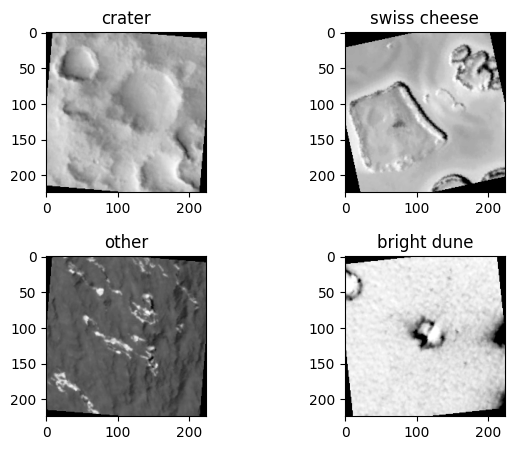

In [7]:
## Check the dataloaders by plotting the imported images
img, label = next(iter(train_loader_2))
figure, axis = plt.subplots(2,2)

axis[0,0].imshow(img[0].permute(1,2,0), cmap = 'Greys_r')
axis[0,0].set_title(int_to_label_map[label[0].item()])

axis[0,1].imshow(img[1].permute(1,2,0), cmap = 'Greys_r')
axis[0,1].set_title(int_to_label_map[label[1].item()])

axis[1,0].imshow(img[2].permute(1,2,0), cmap = 'Greys_r')
axis[1,0].set_title(int_to_label_map[label[2].item()])

axis[1,1].imshow(img[3].permute(1,2,0), cmap = 'Greys_r')
axis[1,1].set_title(int_to_label_map[label[3].item()])

plt.subplots_adjust(
    left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4
)

plt.show()


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
model = models.resnet50(pretrained=True).to(device)

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 8)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0002)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 111MB/s]


In [10]:
'''' # # Creating a CNN-based image classifier.
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.conv_layer_4 = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )

        self.conv_layer_5 = nn.Sequential(
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512))

        self.conv_layer_6 = nn.Sequential(
          nn.Conv2d(512, 256, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(256))

        self.max_pool = nn.MaxPool2d(2)
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=256*3*3, out_features=128),
          nn.Linear(in_features=128, out_features=8),)
    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.max_pool(self.conv_layer_2(x))
        x = self.max_pool(self.conv_layer_3(x))
        x = self.max_pool(self.conv_layer_4(x))
        x = self.max_pool(self.conv_layer_5(x))
        x = self.max_pool(self.conv_layer_5(x))
        x = self.max_pool(self.conv_layer_5(x))
        x = self.conv_layer_6(x)
        x = self.classifier(x)
        return x
# Instantiate an object.
model = ImageClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00007, weight_decay= 0.000005)'''

"' # # Creating a CNN-based image classifier.\nclass ImageClassifier(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.conv_layer_1 = nn.Sequential(\n            nn.Conv2d(1, 32, kernel_size=3, padding=1),\n            nn.ReLU(),\n            nn.BatchNorm2d(32)\n        )\n        self.conv_layer_2 = nn.Sequential(\n            nn.Conv2d(32, 64, kernel_size=3, padding=1),\n            nn.ReLU(),\n            nn.BatchNorm2d(64)\n        )\n        self.conv_layer_3 = nn.Sequential(\n            nn.Conv2d(64, 128, kernel_size=3, padding=1),\n            nn.ReLU(),\n            nn.BatchNorm2d(128)\n        )\n        self.conv_layer_4 = nn.Sequential(\n            nn.Conv2d(128, 512, kernel_size=3, padding=1),\n            nn.ReLU(),\n            nn.BatchNorm2d(512)\n        )\n\n        self.conv_layer_5 = nn.Sequential(\n          nn.Conv2d(512, 512, kernel_size=3, padding=1),\n          nn.ReLU(),\n          nn.BatchNorm2d(512))\n\n        self.conv_layer_6

In [11]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
# do a test pass through of an example input size
summary(model, input_size=[16, 1, IMAGE_WIDTH ,IMAGE_HEIGHT])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 8]                   --
├─Conv2d: 1-1                            [16, 64, 112, 112]        (3,136)
├─BatchNorm2d: 1-2                       [16, 64, 112, 112]        (128)
├─ReLU: 1-3                              [16, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [16, 64, 56, 56]          --
├─Sequential: 1-5                        [16, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [16, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [16, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [16, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [16, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [16, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [16, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [16, 64, 56, 56]   

In [12]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_loader_1))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 1, 224, 224])

Output logits:
tensor([[ 0.2441, -0.0169,  0.1083,  0.1115,  0.2741,  0.0909,  0.0536,  0.0758]],
       device='cuda:0')

Output prediction probabilities:
tensor([[0.1413, 0.1088, 0.1233, 0.1237, 0.1456, 0.1212, 0.1168, 0.1194]],
       device='cuda:0')

Output prediction label:
tensor([4], device='cuda:0')

Actual label:
6


In [13]:
load = False #### SET TO TRUE IF YOU HAVE A PRESAVED CHECKPOINT
if load:
    checkpoint = torch.load("attempt4_2.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['opt_state_dict'])
    results = checkpoint['results']
    done_epochs = checkpoint['epoch']
else:
    results = None
    done_epochs = 0

In [14]:
done_epochs

0

In [15]:
!pip install torchmetrics
from torchmetrics import ConfusionMatrix, Precision, Recall, F1Score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [16]:
from torchmetrics import ConfusionMatrix, Precision, Recall, F1Score

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

     # Define metrics
    precision = Precision(average='macro', num_classes=8, task='MULTICLASS').to(device)
    recall = Recall(average='macro', num_classes=8, task='MULTICLASS').to(device)
    f1 = F1Score(average='macro', num_classes=8, task='MULTICLASS').to(device)

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        # Update metrics
        precision.update(y_pred_class, y)
        recall.update(y_pred_class, y)
        f1.update(y_pred_class, y)


    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    # Compute precision, recall, f1 score, and confusion matrix
    train_precision = precision.compute().item()
    train_recall = recall.compute().item()
    train_f1 = f1.compute().item()


    return train_loss, train_acc, train_precision, train_recall, train_f1


In [17]:
def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    val_loss, val_acc = 0, 0

    # Define metrics
    precision = Precision(average='macro', num_classes=8, task='MULTICLASS').to(device)
    recall = Recall(average='macro', num_classes=8, task='MULTICLASS').to(device)
    f1 = F1Score(average='macro', num_classes=8, task='MULTICLASS').to(device)

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            val_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # Calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

            precision.update(val_pred_labels, y)
            recall.update(val_pred_labels, y)
            f1.update(val_pred_labels, y)




    # Adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)

     # Compute precision, recall, f1 score, and confusion matrix
    val_precision = precision.compute().item()
    val_recall = recall.compute().item()
    val_f1 = f1.compute().item()


    return val_loss, val_acc, val_precision, val_recall, val_f1

In [18]:
# Define the train function
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
          train_dataloader_1: torch.utils.data.DataLoader,
          train_dataloader_2: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          results = None,
          done_epochs = 0):
    # Create empty results dictionary
    if results == None:
        results = {
            "train_loss": [],
            "train_acc": [],
            "train_precision": [],
            "train_recall": [],
            "train_f1": [],

            "val_loss": [],
            "val_acc": [],
            "val_precision": [],
            "val_recall": [],
            "val_f1": []}


    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        if epoch%2 == 0:
            train_dataloader = train_dataloader_1
        else:
            train_dataloader = train_dataloader_2

        train_loss, train_acc, train_precision, train_recall, train_f1 = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer)

        val_loss, val_acc, val_precision, val_recall, val_f1 = val_step(
            model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn)

        # Print out what's happening
        print(
            f"Epoch: {epoch+done_epochs+2} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"train_precision: {train_precision:.4f} | "
            f"train_recall: {train_recall:.4f} | "
            f"train_f1: {train_f1:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f} | "
            f"val_precision: {val_precision:.4f} | "
            f"val_recall: {val_recall:.4f} | "
            f"val_f1: {val_f1:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_precision"].append(train_precision)
        results["train_recall"].append(train_recall)
        results["train_f1"].append(train_f1)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
        results["val_precision"].append(val_precision)
        results["val_recall"].append(val_recall)
        results["val_f1"].append(val_f1)

        torch.save({
                    'model_state_dict':model.state_dict(),
                    'opt_state_dict': optimizer.state_dict(),
                    'results':results,
                    'epoch':epoch + done_epochs
                }, "attemptRES.pt")

    # Return the filled results at the end of the epochs
    return results

In [19]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 65

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_results = train(model=model,
                      train_dataloader_1=train_loader_1,
                      train_dataloader_2=train_loader_2,
                      val_dataloader=val_loader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      results=results,
                      done_epochs=done_epochs)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 1.4655 | train_acc: 0.5037 | train_precision: 0.6825 | train_recall: 0.3933 | train_f1: 0.4003 | val_loss: 1.1043 | val_acc: 0.6640 | val_precision: 0.5427 | val_recall: 0.5742 | val_f1: 0.5185
Epoch: 3 | train_loss: 1.0428 | train_acc: 0.6574 | train_precision: 0.7104 | train_recall: 0.5924 | train_f1: 0.6063 | val_loss: 0.8366 | val_acc: 0.7359 | val_precision: 0.5839 | val_recall: 0.6229 | val_f1: 0.5804
Epoch: 4 | train_loss: 0.8822 | train_acc: 0.7106 | train_precision: 0.7355 | train_recall: 0.6638 | train_f1: 0.6798 | val_loss: 0.8677 | val_acc: 0.7167 | val_precision: 0.5365 | val_recall: 0.7267 | val_f1: 0.5943
Epoch: 5 | train_loss: 0.8147 | train_acc: 0.7247 | train_precision: 0.7391 | train_recall: 0.6904 | train_f1: 0.7019 | val_loss: 0.7261 | val_acc: 0.7516 | val_precision: 0.5685 | val_recall: 0.7155 | val_f1: 0.6128
Epoch: 6 | train_loss: 0.7538 | train_acc: 0.7407 | train_precision: 0.7557 | train_recall: 0.7122 | train_f1: 0.7237 | val_loss: 0.

In [20]:
def plot_loss_curves(results):

    results = dict(list(model_results.items()))

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    val_loss = results['val_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    val_accuracy = results['val_acc']

    accuracy = results['train_acc']
    val_accuracy = results['val_acc']

    precision = results['train_precision']
    val_precision = results['val_precision']

    recall = results['train_recall']
    val_recall = results['val_recall']

    f1 = results['train_f1']
    val_f1 = results['val_f1']




    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

    # Plot precision
    plt.subplot(2, 3, 3)
    plt.plot(epochs, precision, label='train_precision')
    plt.plot(epochs, val_precision, label='val_precision')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot recall
    plt.subplot(2, 3, 4)
    plt.plot(epochs, recall, label='train_recall')
    plt.plot(epochs, val_recall, label='val_recall')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.legend();

    plt.subplot(2, 3, 5)
    plt.plot(epochs, f1, label='train_f1')
    plt.plot(epochs, val_f1, label='val_f1')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.legend();
    plt.tight_layout()

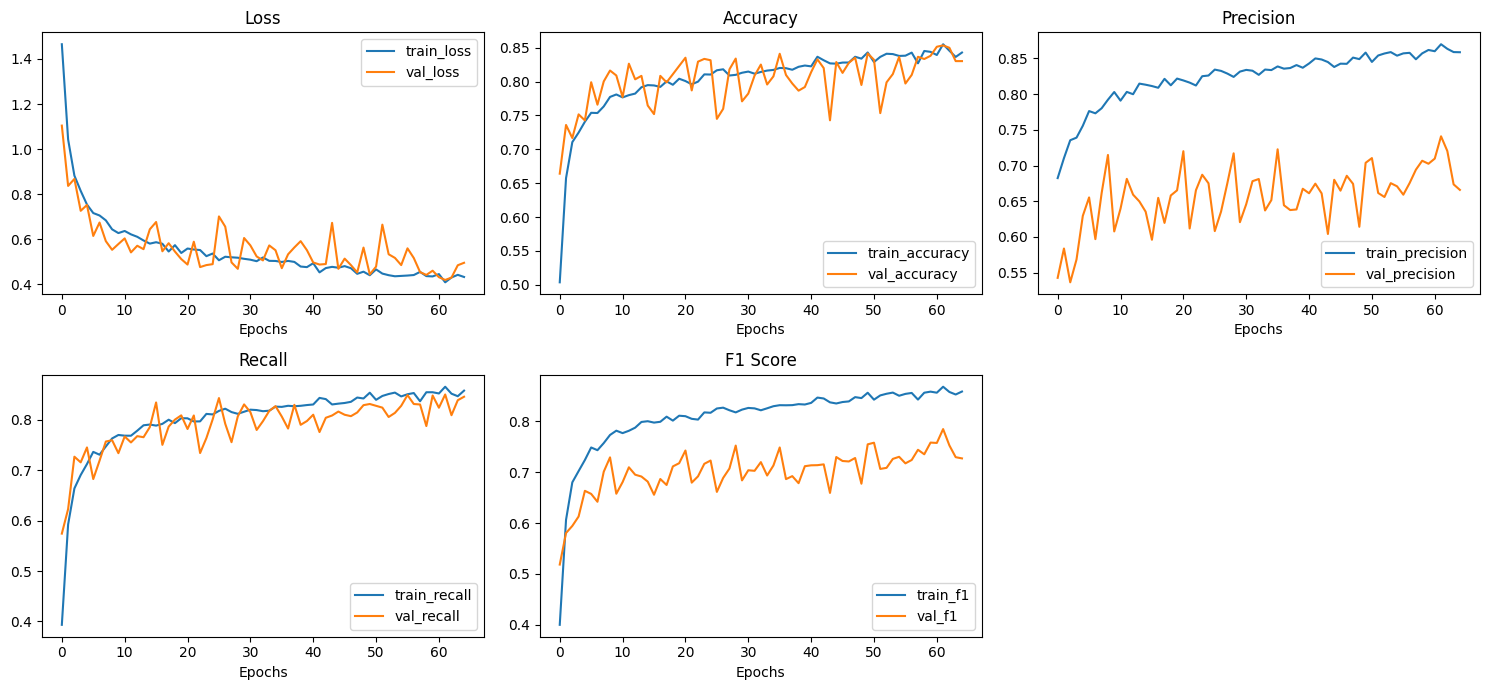

In [22]:
plot_loss_curves(model_results)